In [26]:
from astropy.io import fits
from astropy.modeling import models, fitting

import numpy as np
from scipy import optimize
from pathlib import Path
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
import lmfit
from lmfit.lineshapes import gaussian2d, lorentzian


In [3]:
class Parameter:
    def __init__(self, value):
            self.value = value

    def set(self, value):
            self.value = value

    def __call__(self):
            return self.value

def fit(function, parameters, y, x = None):
    def f(params):
        i = 0
        for p in parameters:
            p.set(params[i])
            i += 1
        return y - function(x)

    if x is None: x = np.arange(y.shape[0])
    p = [param() for param in parameters]
    return optimize.leastsq(f, p)

In [20]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-y)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [42]:
data_path = Path("c:/Users/ajo5182/Documents/astro/y2024-12-09/BC001_Al_FF_243K_HORI_0_0/Analysis/imaging_analysis_20241213/image_reconstruction.fits.gz")
#data_path = Path("c:/Users/ajo5182/Documents/astro/y2024-12-09/BC001_Al_FF_243K_HORI_35_0/Analysis/imaging_analysis_20241213/image_reconstruction.fits.gz")

d = fits.open(data_path) # open fits file

data = d[0].data # data contents of the fits file
shape =  data.shape
imPixelSize = 0.0149

y = imPixelSize * np.linspace((shape[0]-1)/-2,(shape[0]-1)/2, shape[0]) # create array from -23 deg to 23 deg, centered on zero
x = imPixelSize * np.linspace((shape[1]-1)/-2,(shape[1]-1)/2, shape[1]) # create array from -41 deg to 41 deg, centered on zero

peak = np.max(data)
peak_loc = np.unravel_index(np.argmax(data),data.shape)
window = 100

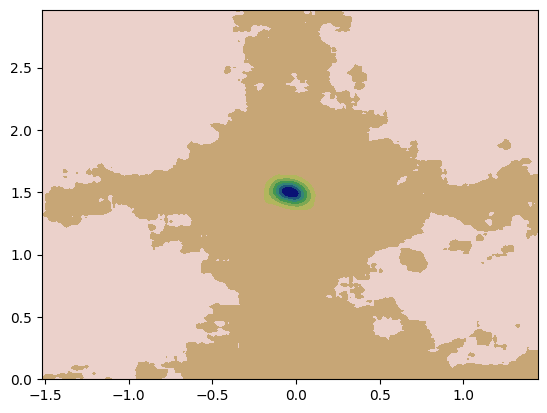

In [43]:
x_window =x [peak_loc[1]-window:peak_loc[1]+window]
y_window =y [peak_loc[0]-window:peak_loc[0]+window]
X,Y = np.meshgrid(x[peak_loc[1]-window:peak_loc[1]+window],y[peak_loc[0]-window:peak_loc[0]+window])
windowed_data = data[peak_loc[0]-window:peak_loc[0]+window, peak_loc[1]-window:peak_loc[1]+window]

plt.contourf(X, Y, windowed_data, cmap=plt.cm.gist_earth_r)




Text(0.95, 0.05, '\nx : 10.7\ny : 9.6\nwidth_x : 4.7\nwidth_y : 5.3')

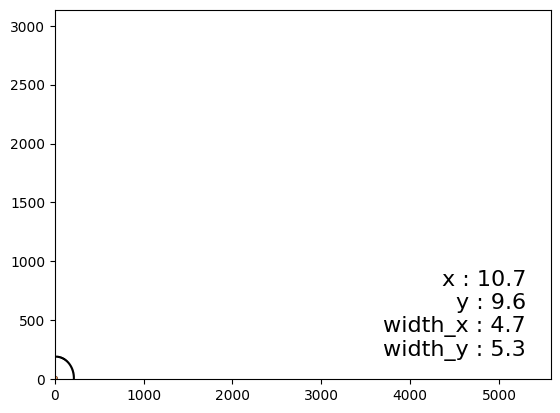

In [41]:
params = fitgaussian(windowed_data)
fit = gaussian(*params)
plt.contour(fit(*np.indices(data.shape)), cmap=plt.cm.copper)
ax = plt.gca()
(height, x, y, width_x, width_y) = params

plt.text(0.95, 0.05, """
x : %.1f
y : %.1f
width_x : %.1f
width_y : %.1f""" %(x, y, width_x, width_y),
        fontsize=16, horizontalalignment='right',
        verticalalignment='bottom', transform=ax.transAxes)

In [55]:
import numpy as np
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt

def fit_rotated_2d_gaussian(data, x=None, y=None, plot_result=False):
    """
    Fit a rotated 2D Gaussian to 2D data using Astropy's Gaussian2D model.

    Parameters:
        data : 2D numpy array
            The input data array to fit.
        x, y : 2D numpy arrays, optional
            Meshgrid coordinates corresponding to data. If None, will be auto-generated.
        plot_result : bool
            Whether to plot the original data and fit result.

    Returns:
        fitted_model : Gaussian2D
            The best-fit Gaussian2D model.
    """
    # Generate coordinate grids if not provided
    ny, nx = data.shape
    if x is None or y is None:
        y, x = np.mgrid[:ny, :nx]

    # Estimate initial parameters
    amplitude_init = np.max(data)
    x_mean_init = x[data == amplitude_init][0]
    y_mean_init = y[data == amplitude_init][0]

    # Initial guess for model
    gauss_init = models.Gaussian2D(amplitude=amplitude_init, x_mean=x_mean_init,
                                   y_mean=y_mean_init, x_stddev=5, y_stddev=5, theta=0)

    # Fitting with Levenberg-Marquardt algorithm
    fitter = fitting.LevMarLSQFitter()
    fitted_model = fitter(gauss_init, x, y, data)

    if plot_result:
        fit_data = fitted_model(x, y)
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(data, origin='lower', cmap='viridis')
        axes[0].set_title("Original Data")
        axes[1].imshow(fit_data, origin='lower', cmap='viridis')
        axes[1].set_title("Fitted Gaussian")
        plt.tight_layout()
        plt.show()

    return fitted_model


# Generate synthetic Gaussian data
def generate_rotated_gaussian_data(amp,xmean,ymean,xstd,ystd,theta):
    y, x = np.mgrid[0:100, 0:100]
    model = models.Gaussian2D(amplitude=3, x_mean=50, y_mean=50,
                              x_stddev=10, y_stddev=20, theta=np.pi/4)
    data = model(x, y) + 0.1 * np.random.normal(size=x.shape)
    return data, x, y

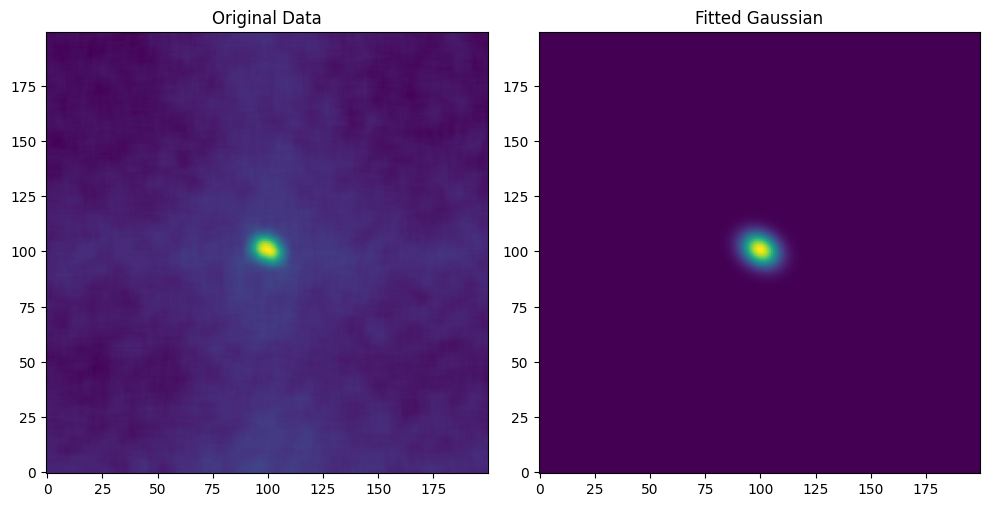

Amplitude: 16232.285811364618
x_mean: -0.03502249122679219
y_mean: 1.4993917046707312
x_stddev: 0.08854017847996849
y_stddev: 0.06981498057905815
theta (radians): 8.867766997048443


In [56]:
fitted = fit_rotated_2d_gaussian(windowed_data, X, Y, plot_result=True)

# Print the fitted parameters
print(f"Amplitude: {fitted.amplitude.value}")
print(f"x_mean: {fitted.x_mean.value}")
print(f"y_mean: {fitted.y_mean.value}")
print(f"x_stddev: {fitted.x_stddev.value}")
print(f"y_stddev: {fitted.y_stddev.value}")
print(f"theta (radians): {fitted.theta.value}")


Amplitude: 16232.285811364618
x_mean: -0.03502249122679219
y_mean: 1.4993917046707312
x_stddev: 0.08854017847996849
y_stddev: 0.06981498057905815
theta (radians): 8.867766997048443

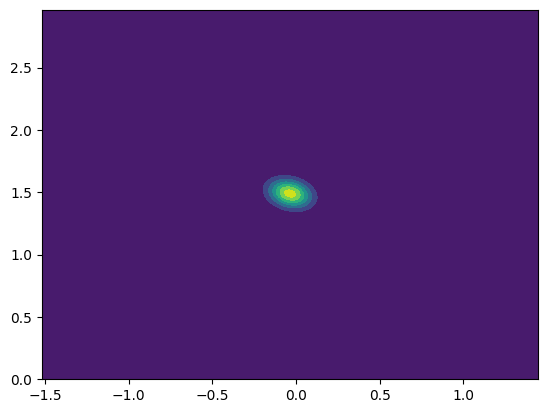

In [59]:
def generate_rotated_gaussian_data(x,y,amp,xmean,ymean,xstd, ystd,theta):
    #y, x = np.mgrid[0:100, 0:100]
    model = models.Gaussian2D(amp,xmean,ymean,xstd, ystd,theta)
    data = model(x, y)
    return data

test = generate_rotated_gaussian_data(X,Y, 16232, -0.035,1.49,0.088,0.069,8.87)
plt.contourf(X,Y,test)